In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
df_23 = pd.read_excel('https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/balanco_programacao_diaria_tm/BALANCO_PROGRAMACAO_DIARIA_2023.xlsx',index_col='din_instante',parse_dates=True)
# df_24 = pd.read_excel('https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/balanco_programacao_diaria_tm/BALANCO_PROGRAMACAO_DIARIA_2024.xlsx')

In [87]:
df = df_23.copy()

In [95]:
df.drop(['id_subsistema', 'nom_subsistema', 'val_gerhidraulica',
       'val_gertermica', 'val_gereolica', 'val_gersolar', 'val_gerpch',
       'val_gerpct', 'val_germmgd'], axis=1, inplace=True)

In [78]:
df_geral = pd.concat([df_23, df_24]).reset_index(drop=True)
df = df_geral[df_geral.id_subsistema == 'NE'].reset_index(drop=True)
df = df_geral[['din_instante','val_carga']]

In [96]:
df.head()

,val_carga
din_instante,
2023-04-29 00:00:00,7505
2023-04-29 00:00:00,12351
2023-04-29 00:00:00,11368
2023-04-29 00:00:00,38868
2023-04-29 00:30:00,7451


In [98]:
df.index.freq = 'MS'

df.head()

ValueError: Inferred frequency None from passed values does not conform to passed frequency MS

<Axes: >

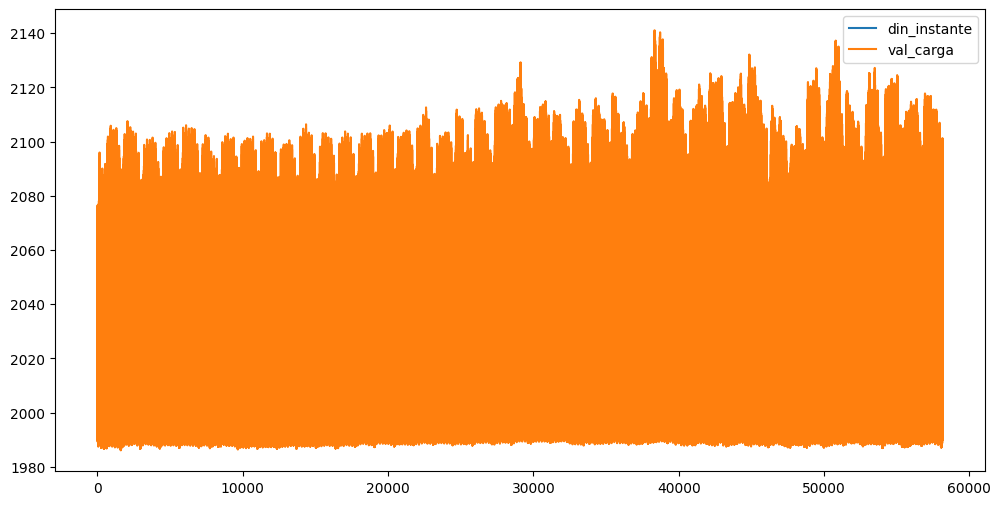

In [45]:
df.plot(figsize=(12,6))

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

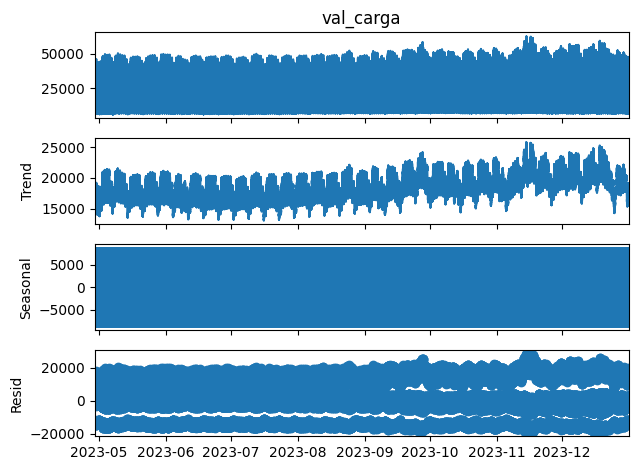

In [99]:
results = seasonal_decompose(df['val_carga'], period=50)
results.plot();

In [55]:
len(df)

58176

In [100]:
train = df.iloc[:40723]
test = df.iloc[40723:]

In [101]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [102]:
df.head(),df.tail()

(                     val_carga
 din_instante                  
 2023-04-29 00:00:00       7505
 2023-04-29 00:00:00      12351
 2023-04-29 00:00:00      11368
 2023-04-29 00:00:00      38868
 2023-04-29 00:30:00       7451,
                      val_carga
 din_instante                  
 2023-12-31 23:00:00      38127
 2023-12-31 23:30:00       6845
 2023-12-31 23:30:00      12618
 2023-12-31 23:30:00      10186
 2023-12-31 23:30:00      37557)

In [103]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [104]:
scaled_train[:10]

array([[0.02862292],
       [0.11424432],
       [0.09687621],
       [0.58275911],
       [0.02766882],
       [0.11125835],
       [0.09033888],
       [0.56369483],
       [0.02662638],
       [0.107813  ]])

In [105]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [106]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [107]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.02862292 0.11424432 0.09687621]
Predict this y: 
 [[0.58275911]]


In [108]:
X.shape

(1, 3, 1)

In [109]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [110]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [111]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [112]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50

40711/40711 [==============================] - 101s 2ms/step - loss: 0.0013
Epoch 2/50
40711/40711 [==============================] - 100s 2ms/step - loss: 8.7939e-05
Epoch 3/50
40711/40711 [==============================] - 103s 3ms/step - loss: 6.3080e-05
Epoch 4/50
40711/40711 [==============================] - 100s 2ms/step - loss: 5.2922e-05
Epoch 5/50
40711/40711 [==============================] - 101s 2ms/step - loss: 4.6460e-05
Epoch 6/50
40711/40711 [==============================] - 101s 2ms/step - loss: 4.0106e-05
Epoch 7/50
40711/40711 [==============================] - 101s 2ms/step - loss: 3.7162e-05
Epoch 8/50
40711/40711 [==============================] - 104s 3ms/step - loss: 3.4548e-05
Epoch 9/50
40711/40711 [==============================] - 115s 3ms/step - loss: 3.1737e-05
Epoch 10/50
40711/40711 [==============================] - 114s 3ms/step - loss: 3.1602e-05
Epoch 11/50
40711/40711 [==============================] - 115s 3ms/step - loss: 2.9720e-05


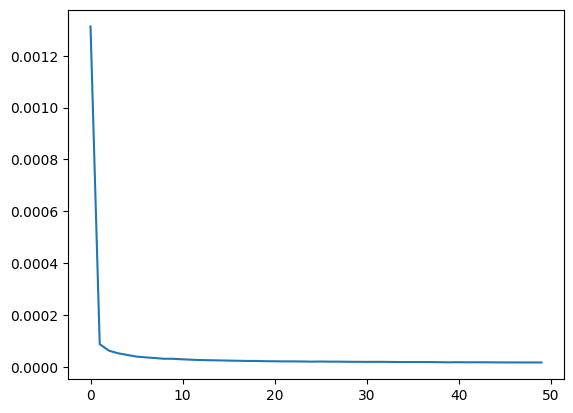

In [114]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [115]:
last_train_batch = scaled_train[-12:]

In [116]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [117]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 294ms/step


array([[0.53451073]], dtype=float32)

In [118]:
scaled_test[0]

array([0.53304004])

In [119]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [120]:
test_predictions

[array([0.53451073], dtype=float32),
 array([0.02736703], dtype=float32),
 array([0.11687317], dtype=float32),
 array([0.07318696], dtype=float32),
 array([0.5279758], dtype=float32),
 array([0.02313849], dtype=float32),
 array([0.11211504], dtype=float32),
 array([0.07473542], dtype=float32),
 array([0.5250882], dtype=float32),
 array([0.01790053], dtype=float32),
 array([0.107058], dtype=float32),
 array([0.07862712], dtype=float32),
 array([0.526641], dtype=float32),
 array([0.01182151], dtype=float32),
 array([0.10272122], dtype=float32),
 array([0.08558801], dtype=float32),
 array([0.53442913], dtype=float32),
 array([0.00617854], dtype=float32),
 array([0.10039295], dtype=float32),
 array([0.09653398], dtype=float32),
 array([0.55090797], dtype=float32),
 array([0.0025198], dtype=float32),
 array([0.10197419], dtype=float32),
 array([0.10972477], dtype=float32),
 array([0.57316065], dtype=float32),
 array([0.00128496], dtype=float32),
 array([0.10727149], dtype=float32),
 array([

In [121]:
test.head()

,val_carga
din_instante,
2023-11-27 02:00:00,36054
2023-11-27 02:30:00,7536
2023-11-27 02:30:00,12634
2023-11-27 02:30:00,9978
2023-11-27 02:30:00,35715


In [122]:
true_predictions = scaler.inverse_transform(test_predictions)

In [123]:
test['Predictions'] = true_predictions

C:\Users\Fellipe\AppData\Local\Temp\ipykernel_4380\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='din_instante'>

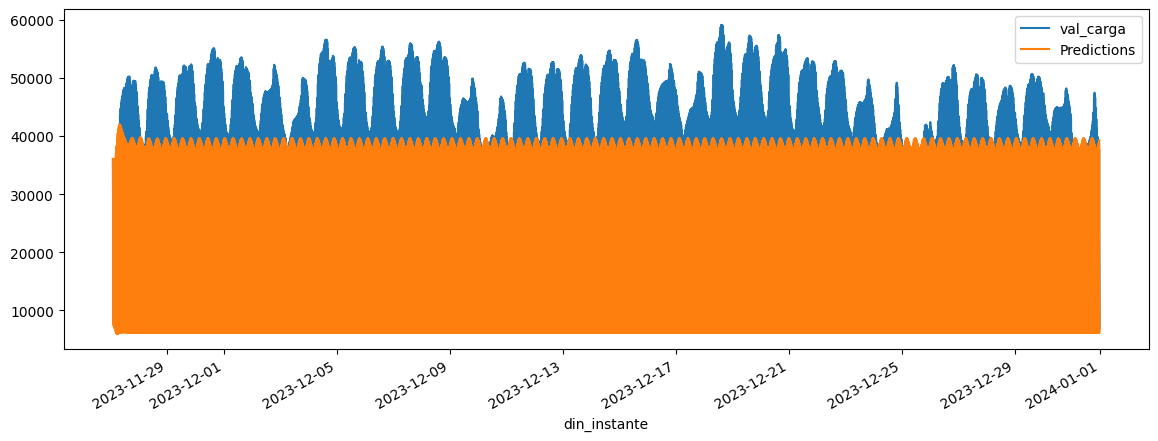

In [124]:
test.plot(figsize=(14,5))

In [126]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['val_carga'],test['Predictions']))
print(rmse)

5115.977710226897


In [128]:
test.to_excel('predicao.xlsx')